<a href="https://colab.research.google.com/github/Jose-Bruno/ProcessamentoDigitalDeImagens/blob/main/Jos%C3%A9_Bruno_da_Silva_Santos_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

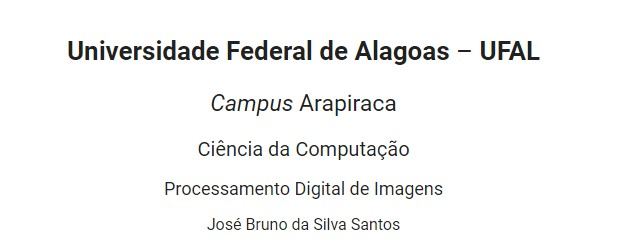

# Implementação - Transformada de Fourier





## Bibliotecas e configurações

In [69]:
from google.colab.patches import cv2_imshow
from skimage import io
from matplotlib import pyplot as plt
import cv2 as cv 
import numpy as np

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imagem Utilizada

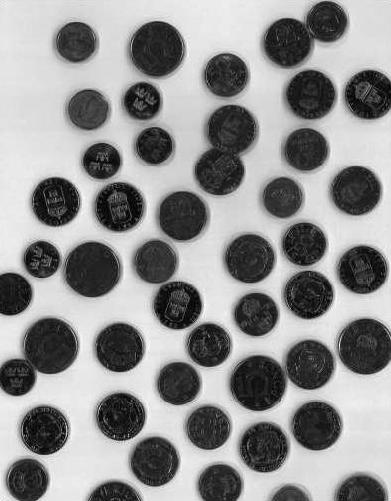

**Carregando Imagem para Utilização**

In [71]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Imagens/coins.jpg"
img = cv.cvtColor(io.imread(image_path), cv.COLOR_RGBA2GRAY)

## Domínio de Frequência



1.   A filtragem no domínio de frequência realiza operações com a Transformada de Fourier de uma imagem e não diretamente na própria imagem.
2.   Geralmente são executados os seguintes passos:
    *   Primeiro é aplicada a transformada de fourier que traz a representação da imagem no espaço para o domínio de frequência;
  *   Então, como os valores no domínio de frequência geralmente são altos, é utilizada uma função logarítmica para baixar os valores e assim melhorar a visualização;
  *   Em seguida é aplicada a operação shift, que leva as baixas frequências para o centro e as altas frequências para as bordas;
  *   Esse é o momento da aplicação de algum filtro na imagem (ainda no domínio de frequência);
  *   Após a aplicação do filtro, é feito o shift inverso para retornar com as baixas frequências nas bordas e as altas no centro;
  *   Por último, é calculada a transformada inversa de fourier para trazer o resultado da imagem filtrada no domínio de frequência para o domínio espacial.











**Transformação de Fourier**

No código abaixo é aplicada a tranformada de fourier na imagem, como função nativa da biblioteca NumPy.

Como resultado se tem o espectro da transformada de fourier com as baixas frequências nos cantos e as altas frequências no centro.

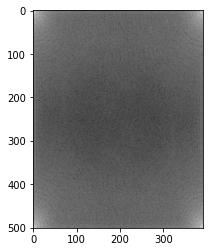

In [72]:
img_fft = np.fft.fft2(img)
plt.imshow(np.log(1 + np.abs(img_fft)), cmap="gray")
plt.show()

**Shift**

No código abaixo é aplicado o shift (também como função nativa do NumPy).

Agora as baixas frequências ficam no centro e as altas ficam nos cantos. Essa composição facilita a utilização dos filtros.

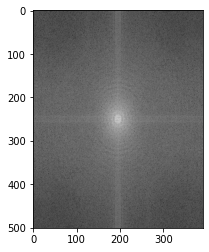

In [73]:
img_fft_shift = np.fft.fftshift(img_fft)
plt.imshow(np.log(1 + np.abs(img_fft_shift)), cmap="gray")
plt.show()

**Shift Inverso**

Após a aplicação de algum filtro, é feito o shift inverso no codigo abaixo.

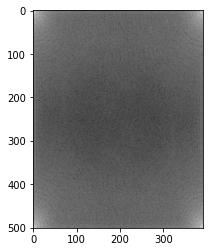

In [74]:
img_fft_shift_inverso = np.fft.ifftshift(img_fft_shift)

plt.imshow(np.log(1 + np.abs(img_fft_shift_inverso)), cmap="gray")
plt.show()

**Transformada Inversa de Fourier.**

Como nenhum filtro foi aplicado a imagem original é restaurada sem perdas de informações

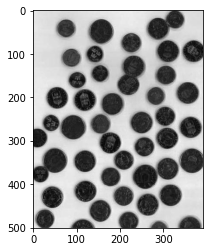

In [75]:
img_fft_inversa = np.fft.ifft2(img_fft_shift_inverso)
plt.imshow(np.abs(img_fft_inversa), cmap="gray")
plt.show()

**Distância Euclidiana**

In [76]:
from math import sqrt

def distancia_euclidiana(point_1,point_2):
    return sqrt((point_1[0]-point_2[0])**2 + (point_1[1]-point_2[1])**2)

## Filtros

### Filtro passa-baixa Gaussiano

* Os filtros passa-baixa gaussianos de duas dimensões têm a forma:
$$
H(u,v) = e^{\frac{-D^2(u,v)}{2D_0^2}}
$$
* $D(u,v)$ é a distância a partir do centro do retângulo de frequência e $D_0$ a frequência de corte.
* Também possui a função de suavizar a imagem (_smoothing/blur_)

código:


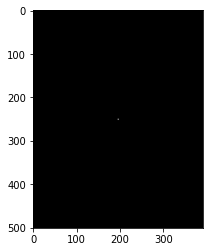

In [77]:
def filtro_passa_baixa_gaussiano(D_0, image_shape, n):
    e = 2.7182
    base = np.zeros(image_shape[:2])
    rows, cols = image_shape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = e ** - (distancia_euclidiana((y, x), center)) ** 2 / (2 * D_0 ** 2)
    return base

img_passa_baixa_gaussiano = filtro_passa_baixa_gaussiano(50, img.shape, 3)
plt.imshow(np.abs(img_passa_baixa_gaussiano), "gray")
plt.show()

Aplicação do filtro na imagem após o shift:

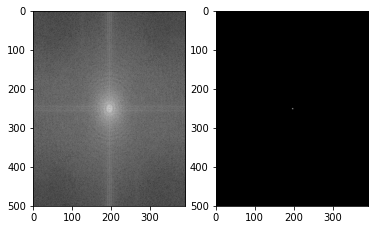

In [78]:
passa_baixa_gaussiano = img_fft_shift * img_passa_baixa_gaussiano

fig = plt.figure()

aux1 = fig.add_subplot(1, 2, 1)
aux1.imshow(np.log(1 + np.abs(img_fft_shift)), cmap="gray")

aux2 = fig.add_subplot(1, 2, 2)
aux2.imshow(np.log(1 + np.abs(passa_baixa_gaussiano)), cmap="gray")

Aplicação do shift inverso:


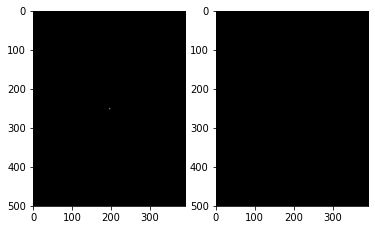

In [79]:
passa_baixa_gaussiano_shift_inverso = np.fft.ifftshift(passa_baixa_gaussiano)

fig = plt.figure()

aux1 = fig.add_subplot(1, 2, 1)
aux1.imshow(np.log(1 + np.abs(passa_baixa_gaussiano)), cmap="gray")

aux2 = fig.add_subplot(1, 2, 2)
aux2.imshow(np.log(1 + np.abs(passa_baixa_gaussiano_shift_inverso)), cmap="gray")

Aplicação da transformada inversa de fourier:

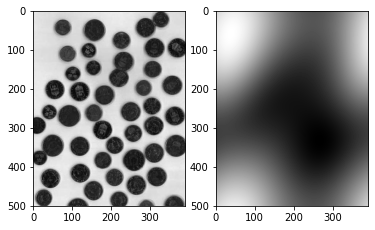

In [80]:
passa_baixa_gaussiano_inverso = np.fft.ifft2(passa_baixa_gaussiano_shift_inverso)

fig = plt.figure()

aux1 = fig.add_subplot(1, 2, 1)
aux1.imshow(img, cmap="gray")

aux2 = fig.add_subplot(1, 2, 2)
aux2.imshow(np.abs(passa_baixa_gaussiano_inverso), cmap="gray")

###Filtro Passa-alta Gaussiano

É Definido por:
$$
H(u,v) = 1 - e^{\frac{-D^2(u,v)}{2D_0^2}}
$$

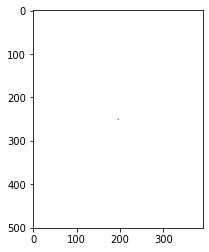

In [81]:
def filtro_passa_alta_gaussiano(D_0, image_shape, n):
    e = 2.7182
    base = np.zeros(image_shape[:2])
    rows, cols = image_shape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 - e ** - (distancia_euclidiana((y, x), center)) ** 2 / (2 * D_0 ** 2)
    return base

img_passa_alta_gaussiano = filtro_passa_alta_gaussiano(50, img.shape, 3)
plt.imshow(np.abs(img_passa_alta_gaussiano), "gray")
plt.show()

Aplicação do shift:

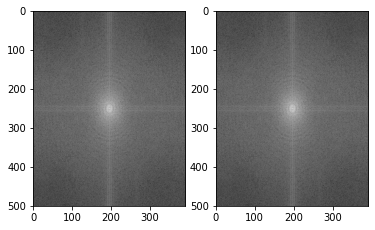

In [82]:
passa_alta_gaussiano = img_fft_shift * img_passa_alta_gaussiano

fig = plt.figure()

aux1 = fig.add_subplot(1, 2, 1)
aux1.imshow(np.log(1 + np.abs(img_fft_shift)), cmap="gray")

aux2 = fig.add_subplot(1, 2, 2)
aux2.imshow(np.log(1 + np.abs(passa_alta_gaussiano)), cmap="gray")

Aplicação do shift inverso:

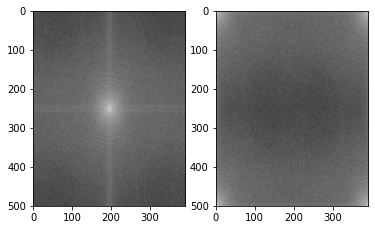

In [83]:
passa_alta_gaussiano_shift_inverso = np.fft.ifftshift(passa_alta_gaussiano)

fig = plt.figure()

aux1 = fig.add_subplot(1, 2, 1)
aux1.imshow(np.log(1 + np.abs(passa_alta_gaussiano)), cmap="gray")

aux2 = fig.add_subplot(1, 2, 2)
aux2.imshow(np.log(1 + np.abs(passa_alta_gaussiano_shift_inverso)), cmap="gray")

Aplicação da transformada inversa de fourier:

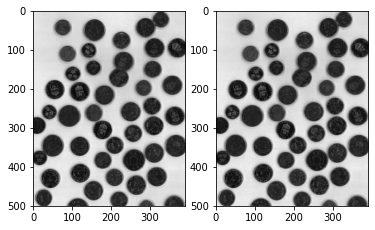

In [84]:
passa_alta_gaussiano_inverso = np.fft.ifft2(passa_alta_gaussiano_shift_inverso)

fig = plt.figure()

aux1 = fig.add_subplot(1, 2, 1)
aux1.imshow(img, cmap="gray")

aux2 = fig.add_subplot(1, 2, 2)
aux2.imshow(np.abs(passa_alta_gaussiano_inverso), cmap="gray")

### Filtro passa-alta ideal

### Filtro passa-alta ButterWorth